# Coding Test - Listing title classifier
This is my solution for the first part of the challenge _"Junior Applied Machine Learning Technical Test"_.

#### Challenge statement reminder
The challenge definition has been made in the following way:
* design a text classifier which will be able to classify a listing title in two categories: ASSET or NON-ASSET ((is the product or not, respectively).
* Three datasets for three different products are provided. The goal is to create a single model for each product using the same method: same algorithm, different data.
* Try at least two or three different methods and compare the results, explaining the advantages and disadvantages for each method. Additionally, provide at least one graphic with the algorithm comparison.
* (Optional) Take into account training and prediction time. How long does the algorithm take to train and predict? Does your selected algorithm work properly under heavy time constraints?

#### Prerequisites
As requested in the challenge statment, the code as to be provided in a Jupyter/Google Colab notebook, available in a GitHub repository.
See the repository's README file for information on how to run this code.

## Setup
First, let's load all the necessary modules, specify some configurations and check if the data folder exists.

In [1]:
# Load all necessary modules.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns # data visualization
sns.set(style="ticks")

import re # special chars removal
from nltk.corpus import stopwords # stopwords removal

# Check stopwords installation
if not stopwords:
    import nltk
    nltk.download('stopwords')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limiting floats output to 3 decimal points

In [2]:
# Data folder
DATA_FOLDER = './data/'

# Avaiable products
PRODUCTS = {
    'MAVIC PRO': 'mavic_pro_data.dat',
    'ONEPLUS': 'oneplus_data.dat',
    'ROOMBA 900 BRUSH': 'roomba_900_brush.dat',
}

# Check data folder existance and dataset files
import os
assert os.path.isdir(DATA_FOLDER), 'Data folder does not exist!'
assert PRODUCTS['MAVIC PRO'] in os.listdir(DATA_FOLDER), 'Mavic Pro data not in data folder!'
assert PRODUCTS['ONEPLUS'] in os.listdir(DATA_FOLDER), 'OnePlus data not in data folder!'
assert PRODUCTS['ROOMBA 900 BRUSH'] in os.listdir(DATA_FOLDER), 'Roomba 900 Brush data not in data folder!'

In [3]:
# The classifier output categories
classification_categories = ['ASSET', 'NON-ASSET']

#### Loading data
It's time to load the datasets. The dataset formats description cames directly from the challenge statements.
Dataset files are in TSV format, having three columns per row:
* *url*: the url from which the info was extracted.
* *Title*: the title for the listing.
* *Label*: is 0 for a positive sample (or sample belonging to the protected product) and 1 for negative samples (or sample not belonging to the protected product).

Usually, to load a dataset from file into a Pandas DataFrame, the functions *read_csv* or (in this case) *read_table* are used.
However, with this particular datasets some error occured during the parsing, probably because there some tabular delimiter inside the middle column (and the tsv format use tabs to differentiate columns).
To cope with this issue, a custom function is created.

In [4]:
# Column names
column_names = ['url', 'Title', 'Label']

def read_tsv(product_name: str) -> pd.DataFrame:
    """
    Custom function to read tsv data files, in order to overcome multiple delimiters inside data.
    
    Args:
        product_name (str): the name of the product dataset to load.
    
    Returns:
        A Pandas DataFrame.
    """
    # Dataset filepath
    filepath = DATA_FOLDER + PRODUCTS[product_name]
    
    # Create and empty dataset
    df = pd.DataFrame(columns=column_names)
    
    # Temporary variables to store row data
    row_data_urls = list()
    row_data_titles = list()
    row_data_labels = list()
    
    # For each line of the file...
    with open(filepath) as fp:
        for i, line in enumerate(fp):
            # Split line on all whitspaces
            splitted_line = line.split()
            
            # A line should be splittable in at least 3 parts:
            # a row has to hold at least 3 column
            if len(line) < 3:
                print(f'Error at line {i}: line not splittable in three parts.')
                continue
            
            # The first field is the url
            row_data_urls.append(splitted_line[0])
            
            # The ones in the middle are the 'Title'
            row_data_titles.append(' '.join(splitted_line[1:-2]))
            
            # The last one is the 'Label'
            row_data_labels.append(int(splitted_line[-1]))
    
    # Populate the dataset with the row data
    df = pd.DataFrame({
        'url': row_data_urls,
        'Title': row_data_titles,
        'Label': row_data_labels,
    }, columns=column_names)
    
    return df.copy()
    

# Load ONEPLUS data
df_oneplus = read_tsv('ONEPLUS')

# Load MAVIC PRO data
df_mavic = read_tsv('MAVIC PRO')

# Load MAVIC PRO data
df_roomba = read_tsv('ROOMBA 900 BRUSH')

## Exploring data
We've already a lot of information about the data, but just to be sure let's confirm the datasets sizes and labels numbers.

In [5]:
distribution_data_positive = list()
distribution_data_negative = list()

# Get the number of positive and negative samples for each dataset
for df in [df_mavic, df_oneplus, df_roomba]:
    distribution_data_positive.append(df.loc[df['Label'] == 0, 'Label'].count())
    distribution_data_negative.append(df.loc[df['Label'] == 1, 'Label'].count())

# Create a simple table for better visualization (and understanding)
pd.DataFrame({
    'Num samples': [len(df_mavic), len(df_oneplus), len(df_roomba)], 
    'Positive': distribution_data_positive,
    'Negative': distribution_data_negative,
}, index=list(list(PRODUCTS.keys())))

,Num samples,Positive,Negative
MAVIC PRO,5335,1422,3913
ONEPLUS,5612,1959,3653
ROOMBA 900 BRUSH,696,329,367


Regarding the text contained in the _Title_ column, it'd be useful to see how many (unique) words there are.

In [6]:
# Create a simple table for better visualization (and understanding)
pd.DataFrame({
    'Number of unique words': [df['Title'].apply(lambda x: len(x.split(' '))).sum() for df in [df_mavic, df_oneplus, df_roomba]],
}, index=list(list(PRODUCTS.keys())))

,Number of unique words
MAVIC PRO,91689
ONEPLUS,109672
ROOMBA 900 BRUSH,13458


#### Missing values
Before the next step, we should consider the possibilty of missing values in our datasets.
We've checked and there are none. Nevertheless, let's put a checkpoint just in case.
let's take a moment to check if our datasets have missing values that could create problems with the model.

In [7]:
assert not sum([df.isnull().sum().sum() for df in [df_mavic, df_oneplus, df_roomba]]), \
    'There shouldn\'t be missing values. Check the datasets.'

## Feature engineering
### Text pre-processing
For these particular datasets, our text cleaning steps includes: remove html quotation mark, remove stop words, change text to lower case, remove punctuation, remove symbols as parenthesis, hastag, etc.
The removal of unimportant entities would increase the accuracy, because size of sample space of possible features set decreases.

When dealing with document or sentences, it's also useful to normalize words with techniques like Lemmatization or Stemmming. However, here we're dealing with title of products that are usually not made by a lot of words, usually simple ones, few verb conjugations, we'll not apply these tecniques for now.  
Also, bad products could differ from the real one by small derivations (Mavics instead of Mavic) and we'd like the model to capture these differences.

In [8]:
# Use english stopwords for now
STOPWORDS = set(stopwords.words('english'))

def text_cleaning(text: str) -> str:
    """
    Perform the following cleaning steps to a specific text:
     - remove symbols,
     - remove '&quot;' symbol (html quotation mark),
     - remove stop words,
     - change text to lower case,
     - remove punctuation.
     
    Args:
        text (str): text to be cleaned.
    
    Returns:
        A cleaned text.
    """
    BAD_SYMBOLS_RE = re.compile('[!"#$%&\'()*+,-./:;<=>?@\[\]^_`{|}~]')
    
    # Delete bad symbols
    text = BAD_SYMBOLS_RE.sub('', text)
    
    # Remove '&quot;' symbol
    text = text.replace('&quot;', '')
    
    # Stopwords removal
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    # To lower case
    text = text.lower()
    
    return text

df_oneplus['Title'] = df_oneplus['Title'].apply(text_cleaning)
df_mavic['Title'] = df_mavic['Title'].apply(text_cleaning)
df_roomba['Title'] = df_roomba['Title'].apply(text_cleaning)

Note: another thing that could be done to improve our models is try not to remove the words (or numbers, symbols, etc) contained in the product name.  
For example, if the product name is 'The Roomba', 'The' is an important part of the name and thus should not be deleted (in this case it is, since 'The' is contained in the english stopwords).

Note: another approach could be leave *Label* numeric (0s and 1s) and convert the values into the catogories at prediction time.

### Feature extraction: convert words into numerical features
In order to run a machine learning model we need to convert titles and hence words into numerical features vectors.
Here, a model called _Bag of Words_ is used, where a vector represents the frequency of a word in a predefined dictionary of words.
We will convert text to a matrix of token counts (using *CountVectorizer*), then transform a count matrix to a normalized tf-idf representation (using *TfidfTransformer*).  
We'll use Scilkit-Learn *Pipelines* to make the process cleaner and reproducible for all the models and products.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Create the pre-processing pipeline
# note: we define here a 'placeholder' clf that will be replaced later
pipeline = Pipeline(steps = [('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', None),
                            ])

Note: A next step could be specify *max_features* parameter for *CountVectorizer*, limiting the number of terms. 

## Performance metrics
The more common metrics are the following:
* *Accuracy* is the most intuitive performance metric: it’s the number of correct predictions over all predictions made. While it’s easy to interpret the accuracy, it’s doesn’t give enough information about the instances the classifier missed.
* *Precision* is the fraction of relevant instances among the retrieved instances. Usually this metric is used when we care about reducing the false positives.
* *Recall* (also called *Sensitivity* or *True positive rate*) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. Recall is usually used when we care about reducing the false negatives.
* *Precision-Recall Trade-off*: one can easily have a 100% recall by classifying every sample as positive. But in doing so, you’ll have a lot of False positives,thus having a very low precision. It's pobbile then to get a better sense of this trade-off by looking at the precision recall curve.
* *f1-score* it’s the harmonic mean of Precision and Recall. It gives more weights to lower values and favors values that are equal. A higher f1_score will appear only if the precision and recall are high too.

Note that all the metrics except accuracy are computed towards one label and we want to be sure that the positive (0) label are our true positive.
To evaluate the model performance we'll use Stratified KFold cross-validation using 5 folds, which means roughly 20% of the data is used for testing. We use the stratified version to preserve the percentage of samples for each class.

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.scorer import make_scorer

# Define custom scoring function for supporting
# class-based precision and recall
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary', pos_label=0),
    'recall': make_scorer(recall_score, average='binary', pos_label=0),
    'f1_score': make_scorer(f1_score, average='binary', pos_label=0),
}

# Define the validation function using (Stratified)KFold
def model_validation(pipeline: Pipeline, df: pd.DataFrame, n_folds: int = 5) -> dict:
    X, y = df['Title'], df['Label']
    
    kf = StratifiedKFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
        
    score = cross_validate(pipeline, X, y, cv=kf, scoring=scoring_metrics)
        
    return score

#### Train-test splitting
Before starting with the next section, let's split our datasets for training and testing.
The first set will again be splitted and use for validation using the (Stratified)K-Fold CV.
Instead, the test set will be used for the predictions and the computational cost evaluation at the end.

In [18]:
# For MAVIC PRO
temp_copy = df_mavic.copy()
df_mavic_train_val = temp_copy.sample(frac=0.80, random_state=42)
df_mavic_test = temp_copy.drop(df_mavic_train_val.index)

# For ONEPLUS
temp_copy = df_oneplus.copy()
df_oneplus_train_val = temp_copy.sample(frac=0.80, random_state=42)
df_oneplus_test = temp_copy.drop(df_oneplus_train_val.index)

# For ROOMBA
temp_copy = df_roomba.copy()
df_roomba_train_val = temp_copy.sample(frac=0.80, random_state=42)
df_roomba_test = temp_copy.drop(df_roomba_train_val.index)

## Model selection
The models that we're going to test are:
* *Multinomial Naive Bayes*,
* *Linear Support Vector Machine*,
* *Random Forest*.

Each model has to be execute on all the three different products dataset.
For this purpose, we've created a function that:
1. takes the model pipeline has input,
2. replace the current model being tested inside the pipeline,
3. for each product, runs the model using the validation method described above,
4. create a report for the defined metrics using a table.

#### Multinomial Naive Bayes
The Naive Bayes classifier is a simple probabilistic classifier which is based on Bayes theorem with strong and naïve independence assumptions. It is one of the most basic text classification techniques and despite the naïve design and oversimplified assumptions it usually performs well in many complex real-world problems.    
Though it is often outperformed by more advanced techniques, it's less computationally intensive (in both CPU and memory) and it requires a small amount of training data.  
The Multinomial variation takes into account the number of occurrences of a term in training documents from class c, including multiple occurrences.

In [24]:
from sklearn.naive_bayes import MultinomialNB 

def model_selection(model: Pipeline) -> pd.DataFrame:
    # Remove last classifer from the pipeline
    pipeline.steps.pop(2)
    
    # And replace it with the current classifier
    pipeline.steps.append(['clf', model])
    
    # temporary list for all the products
    temporary_store = list()
    
    # For each product/dataset
    for df in [df_mavic_train_val, df_oneplus_train_val, df_roomba_train_val]:
        # Run (Stratified)KFold
        scores = model_validation(pipeline, df)
        
        # Store product-data
        product_result = pd.Series({
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean(),
            'F1-score': scores['test_f1_score'].mean(),
        })
        
        temporary_store.append(product_result)
                    
    # Create the final table
    return pd.DataFrame(temporary_store, index=list(PRODUCTS.keys()))


# Run model selection for Multinomial Naive Bayes
model_res = model_selection(MultinomialNB())
print(model_res)

                  Accuracy  Precision  Recall  F1-score
MAVIC PRO            0.975      0.941   0.971     0.956
ONEPLUS              0.986      0.961   0.999     0.980
ROOMBA 900 BRUSH     0.885      0.816   0.985     0.892


From the above results we can say that:
* the overall accuracy is pretty good (see [Uncommonly-high-accuracy](Coding_Test_-_Listing_title_classifier.ipynb#Uncommonly-high-accuracy) paragraph).
* The accuracy is lower for the Roomba dataset, which is understandable since the size is almost ten times less.
* More or less with all three cases we notice a lower precision than recall. Remember that recall measure what should have been predicted as positive but we flagged as negative.  

Therefore, this model enhance recall over precision.

#### Linear Support Vector Machine
Support Vector Machines determines the best decision boundary (best hyperplane) between vectors that belong to a given group and vectors that do not belong to it (divides the space into two subspaces).  
SVM is very effective in text-mining tasks, particularly due to its effectiveness in dealing with high-dimensional data (SVM does not use all the data points or vectors to choose the boundary).  
However, they usually are memory-intensive during training time due to the fact that a NxN kernel matrix has to be stored. If not, you'll need to recompute the kernel values repeatedly, making the training much slower.
At prediction time, SVM takes a linear combination of all support vectors so, if there are a lot of them it'll required a lot of memory.  

We'll uses Scikit-Learn _SGDClassifier_ (with 'hinge' loss) because it implements stochastic gradient descent instead of the exact gradient descent and may generalize better (downside is it may not converge to the same solution as an exact method).

In [16]:
from sklearn.linear_model import SGDClassifier

# Run model selection for Linear Support Vector Machin
model_res = model_selection(SGDClassifier())
print(model_res)

                  Accuracy  Precision  Recall  F1-score
MAVIC PRO            0.995      0.993   0.989     0.991
ONEPLUS              0.999      0.999   0.998     0.998
ROOMBA 900 BRUSH     0.977      0.985   0.966     0.975


With the SVM the accuracy is higher than with the previous model, even if it is by a little amount.
Besides, this differ from the previous model since the precision is usually higher than the recall.

#### Conclusions: precision - recall trade-off
What would we rather have: predict as ASSET a NON-ASSET product (False Positive) or the other way around (False Negative)?
Since it's better to flag an ASSET product a NON-ASSET product and then manually removed (if it's too much it can cause problem of course) than not flag an NON-ASSET that in reality it is an ASSET (and we've miss it!), we choose the second model. Moreover, it'd be not good if the recall was very low, but since the difference is very minimal, this should work.

#### Uncommonly high accuracy
At first look, we notice that the metrics are overall very high, several times nearly 100%. This is very uncommon and seldom occurs in standard classifcation tasks.
What could be wrong? Well, this scanario may occur when:
* the classification problem is rather easy,
* test and training data are too much alike compared to practical scenarios (so the model will probably generalize bad),
* re-classifying training data in the test steps (some train data is leaked into the train data),
* the classifier is overfitting the training set.

A train/validation/test set splitting or a K-fold cross validation should avoid the latter case. We apply a (Stratified) 5-fold c.v. with data shuffling. This should also prevent train data leaking into train data, since the splitting is completly handled by sklearn methods.  
A helpful approach could be to try to visualize data (both training and testing) to get an indication on how complicated the problem is, if the testing data is too similar to the training data, etc.

#### Model selection: a graphical representation
Usually for model performance (and comparision) a ROC curve is used. Instead, when dealing with unbalanced classes a Precion-Recall curve is preferred.
In our case, a ROC curve is not feasible, since SGDClassifier with hinge loss cannot predict the probabilities required to construct a ROC curve. 
For the Precion-Recall curve, instead, since the nature of the plot and the very close values a rapresentation of this type is not very useful.
We'll use instead a box-plot of the F1-score (that takes into consideration both precision and recall) values for all the fold (see points in the plot), for the ROOMBA dataset, the one that holds more difference with the two models.

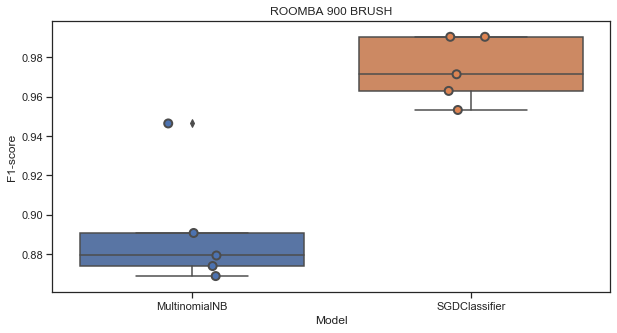

In [32]:
def plot_scores(scores:list, title: str):
    # Construct DataFrame for visualization
    scores_df = pd.DataFrame(scores, columns=['Model', 'Fold id', 'F1-score'],)
    
    # Set the size
    fig, _ = plt.subplots(figsize=(10, 5))
    
    # Plot data
    sns.boxplot(x='Model', y='F1-score', data=scores_df).set_title(title)
    sns.stripplot(x='Model', y='F1-score', data=scores_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
    
scores_data = list()

# Run the comparision for the two models
for model in [MultinomialNB(), SGDClassifier()]:
    # Remove last classifer from the pipeline
    pipeline.steps.pop(2)

    # And replace it with the current classifier
    pipeline.steps.append(['clf', model])
    
    # Run (Stratified)KFold
    scores = model_validation(pipeline, df_roomba_train_val)
    
    # Store the f1-scores (one for each fold) for this model
    for fold_idx, f1_score in enumerate(scores['test_f1_score']):
        scores_data.append((model.__class__.__name__, fold_idx, f1_score))

plot_scores(scores_data, list(PRODUCTS.keys())[2])

### Computational time
After the model selection we've decided to use the SVM as our final algorithm.
Now, let's try to get an idea on how much time it requires to train and to predict new samples.
We'll re-train the selected model using the entire train-val set and make predictions using samples from the (unseen) test set.

In [42]:
import time
import random

# Re-create the entire pipeline
pipeline = Pipeline(steps = [('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', SGDClassifier()),
                            ])

def compute_training_prediction_time(df_train_val: pd.DataFrame, df_test: pd.DataFrame) -> dict:
    # For semplicity, rename columns with X and y
    X_train, y_train = df_train_val['Title'], df_train_val['Label']
    X_test, y_test = df_test['Title'], df_test['Label']
    
    # Fit on the whole train(-val) set
    t = time.time_ns()
    pipeline.fit(X_train, y_train)
    fit_time = time.time_ns() - t
        
    # For predictions, let's randomly take 5 samples from X_test
    # and then take the average
    predict_times = []
    for x in range(1, 5):
        # Random sampling
        random_test_sample = X_test.sample(n=1, random_state=42)
    
        # Predict
        t = time.time_ns()
        y_pred = pipeline.predict(random_test_sample)
        pred_time = time.time_ns() - t
        
        predict_times.append(pred_time)
    
    # The timing are returned in milliseconds
    return {
        'Training time (ms)': fit_time / 1000000,
        'Prediction time (ms)': np.array(predict_times).mean() / 1000000,
    }


timing_mavic = compute_training_prediction_time(df_mavic_train_val, df_mavic_test)
timing_oneplus = compute_training_prediction_time(df_oneplus_train_val, df_oneplus_test)
timing_roomba = compute_training_prediction_time(df_roomba_train_val, df_roomba_test)

# Create a simple table for visualization
timing = pd.DataFrame([timing_mavic, timing_oneplus, timing_roomba], index=list(PRODUCTS.keys()))
print(timing)

                  Training time (ms)  Prediction time (ms)
MAVIC PRO                     84.000                 0.688
ONEPLUS                       83.273                 0.719
ROOMBA 900 BRUSH              13.042                 0.724


From the table above, we can see that the avarage training time takes less than 100 milliseconds for the larger dataset, while less than a millisecond for predicting a sample (a title).  
Note that the function compute the timing using time in nanoseconds since the epoch (click [here](https://docs.python.org/3/library/time.html#epoch) for more info on epoch) and thus do not consider only the (real) cpu execution time. This may cause little variations for each execution.